In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, last_tune_log, tune, Verbosity
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "021"
run = wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "nyt-connections"},
)

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
distill_tasks = tasks[:436]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
random.seed(42)
random.shuffle(train_tasks)
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(436, 72, 92, 436)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0

expected_tokens = 4000  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 5e-6
model = models.qwen_7b()
wandb.config["model"] = model_name = model.base_model
num_iterations = 10
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 64
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 8
wandb.config["tasks_per_iter"] = tasks_per_iter = 2 # 8
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Iteration 2
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/021/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/021/0001 --port=8001 --api-key=default
INFO 02-20 03:31:35 __init__.py:190] Automatically detected platform cuda.
INFO 02-20 03:31:37 api_server.py:840] vLLM API server version 0.7.2
INFO 02-20 03:31:37 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/021/0001', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', r

Loading pt checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading pt checkpoint shards:  50% Completed | 1/2 [00:07<00:07,  7.22s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:12<00:00,  5.83s/it]
Loading pt checkpoint shards: 100% Completed | 2/2 [00:12<00:00,  6.03s/it]



INFO 02-20 03:32:13 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-20 03:32:14 worker.py:267] Memory profiling takes 0.91 seconds
INFO 02-20 03:32:14 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-20 03:32:14 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 5.65GiB; the rest of the memory reserved for KV Cache is 55.08GiB.
INFO 02-20 03:32:15 executor_base.py:110] # CUDA blocks: 32228, # CPU blocks: 46811
INFO 02-20 03:32:15 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 62.95x
INFO 02-20 03:32:57 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.07 seconds
INFO 02-20 03:32:58 api_server.py:756] Using supplied chat template:
INFO 02-20 03:32:58 api_server.py:756] None
INFO 02-20 03:32:58 launcher.py:21] Available routes are:
INFO 02-20 03:32:58 launcher.py:29] Route: /

INFO:     Started server process [21187]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-20 03:33:00 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:38128 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7310c29ba700>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/128 [00:00<?, ?it/s]

Best iteration: 2
Current iteration: 2


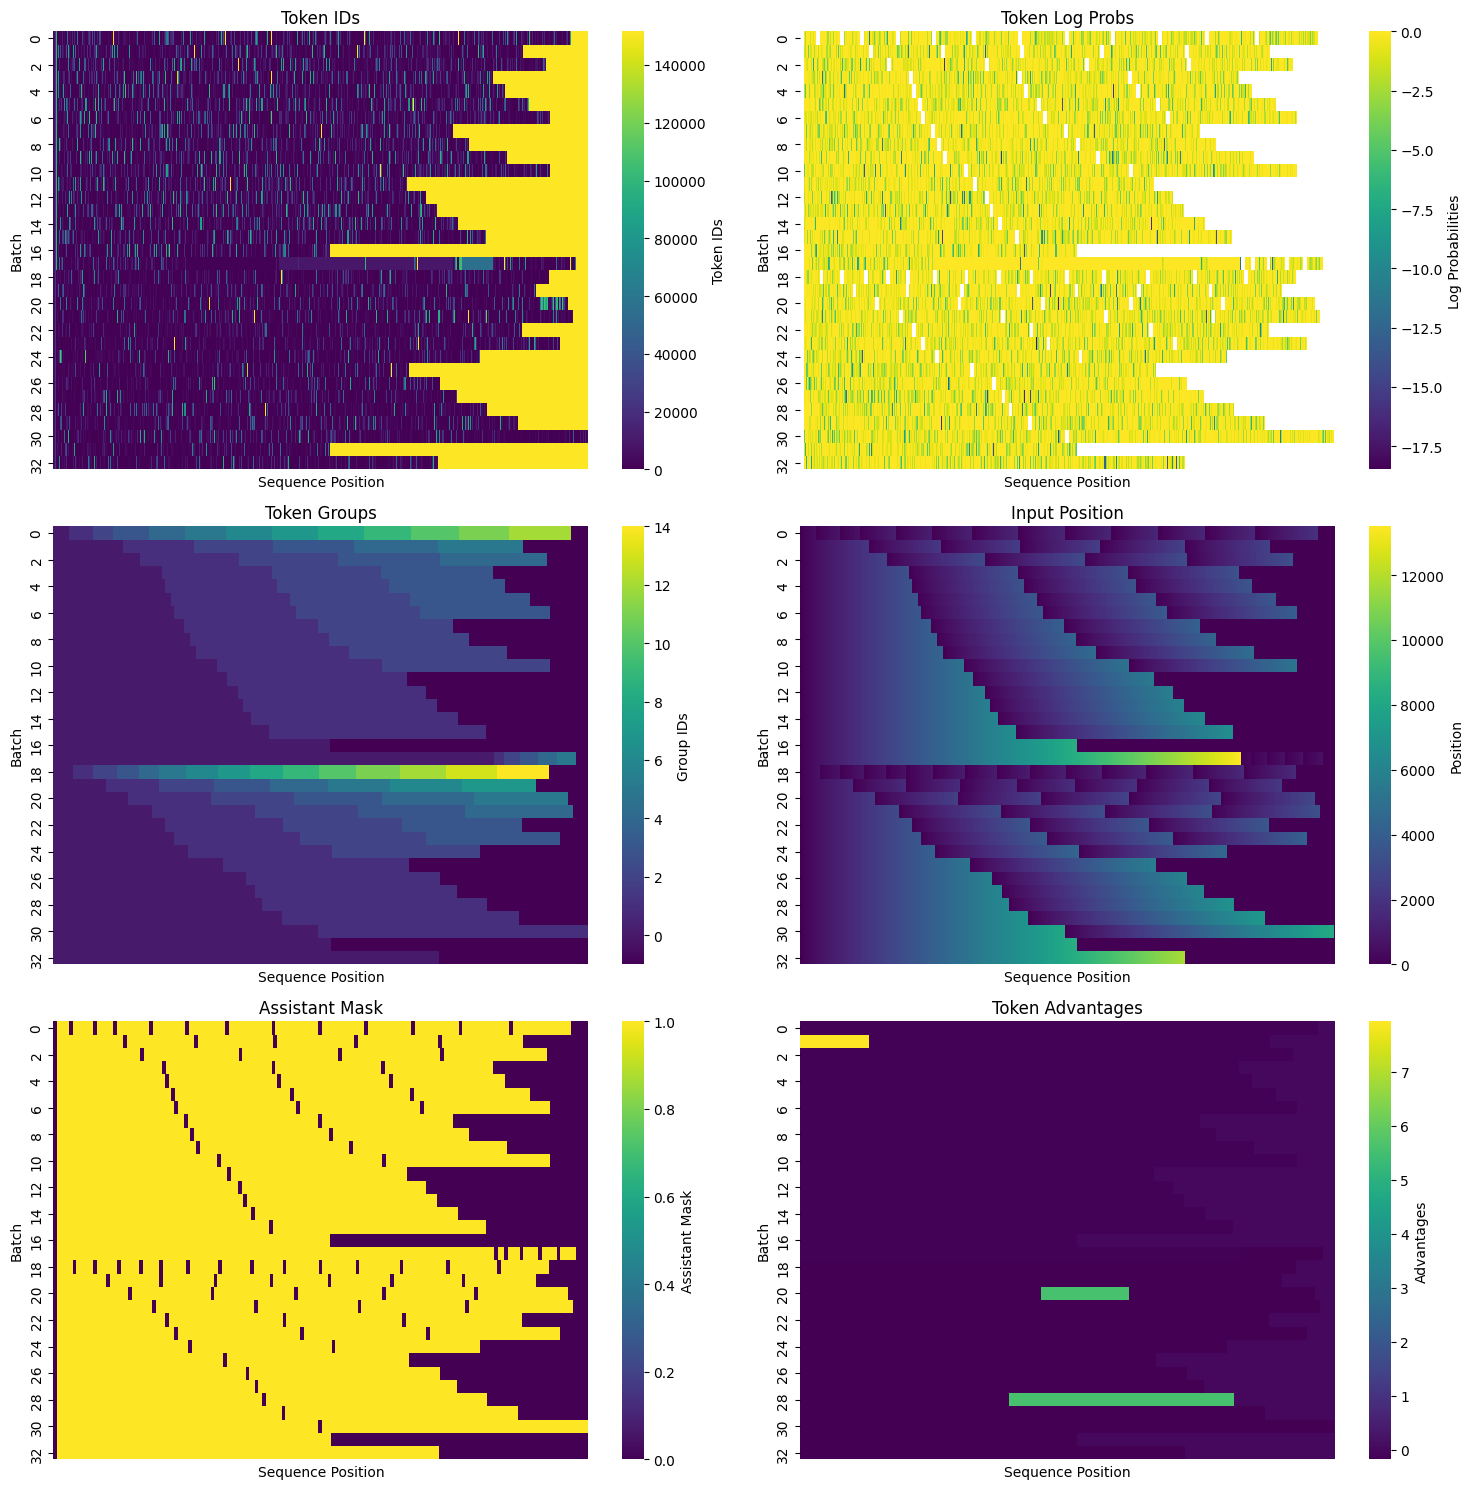

Using reference checkpointer
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/021/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/021
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/021/tensors
  num_seque

Writing logs to models/021/logs/log_1740022687.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 34.10 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|10|Loss: 0.3622:  62%|██████▎   | 10/16 [04:53<02:50, 28.39s/it, entropy=2.06, kl_div=0.534, loss=0.362, policy=0.46]   

In [ ]:
for i in range(get_iteration(output_dir), num_iterations + 1):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.2 * vllm.max_concurrent_tokens / expected_tokens)
    )
    semaphore = asyncio.Semaphore(int(1.33 * vllm.max_concurrent_tokens / expected_tokens))
    offset = (i - 1) * stride
    (_, val_stats), (train_results, train_stats) = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": val_stats.completion_tokens / val_stats.usages,
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = round(wandb_data["tokens"])
    vllm.process.terminate()
    kill_vllm_workers()
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i - 1])
    except Exception:
        pass
    packed_tensors = packed_tensors_from_tokenized_results(
        [
            result
            for results in train_results
            for result in results
            if result.advantage != 0
        ],
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(model.tune_optimizer, lr=lr)
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=8,
        ),
        verbosity=verbosity,
    )
wandb.finish()